In [131]:
#Importamos librerias que vamos a usar
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Gráficos
import matplotlib.pyplot as plt

# Preprocesado y modelado
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuración warnings
import warnings
warnings.filterwarnings('once')

In [132]:
# Cargar los datasets
train_df = pd.read_csv('/content/drive/MyDrive/data science/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data science/test.csv')

print("Dimensiones del set de entrenamiento:", train_df.shape) # Imprimimos para ver
print("Dimensiones del set de prueba:", test_df.shape) # Imprimimos para ver

# Vistazo rápido a los primeros registros del set de entrenamiento
print("\nPrimeras filas del set de entrenamiento:")
train_df.head(3) # Imprimimos para ver

Dimensiones del set de entrenamiento: (891, 12)
Dimensiones del set de prueba: (418, 11)

Primeras filas del set de entrenamiento:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


##A)Debemos describir brevemente la cantidad de valores faltantes para cada una de las variables de la base de datos.

In [133]:
# Calcular valores faltantes para el set de entrenamiento
missing_train = train_df.isnull().sum()
missing_train = missing_train[missing_train > 0] # Filtrar solo las columnas con 0 para que sea mas limpio
print("Valores faltantes en train.csv:") # Imprimimos para ver
print(missing_train)
print("-" * 30) # Separamos con _

# Calcular valores faltantes para el set de prueba
missing_test = test_df.isnull().sum()
missing_test = missing_test[missing_test > 0] # Filtrar solo las columnas con 0
print("Valores faltantes en test.csv:") # Imprimimos para ver
print(missing_test)

Valores faltantes en train.csv:
Age         177
Cabin       687
Embarked      2
dtype: int64
------------------------------
Valores faltantes en test.csv:
Age       86
Fare       1
Cabin    327
dtype: int64


## b) Completar aquellas variables que se encuentran faltantes para las bases de train (“Age”,”fare”, “Cabin”) y test ( “Age”, “Cabin”, “embarked”).

In [134]:
# --- Imputación para el set de ENTRENAMIENTO (train.csv) ---

# Rellenar 'Age' con la mediana
median_age_train = train_df['Age'].median()
train_df['Age'] = train_df['Age'].fillna(median_age_train)

# Rellenar 'Embarked' con la moda
mode_Embarked_train = train_df['Embarked'].mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(mode_Embarked_train)

# Rellenar 'Cabin' con 'U' solo para que de 0 porque despues lo borro
train_df['Cabin'] = train_df['Cabin'].fillna('U')


# --- Imputación para el set de PRUEBA (test.csv) ---

# Rellenar 'Age' con la mediana
median_age_test = test_df['Age'].median()
test_df['Age'] = test_df['Age'].fillna(median_age_test)

# Rellenar 'Fare' con la mediana
median_Fare_test = test_df['Fare'].median()
test_df['Fare'] = test_df['Fare'].fillna(median_Fare_test)

# Rellenar 'Cabin' con 'U' solo para que de 0 porque despues lo borro
test_df['Cabin'] = test_df['Cabin'].fillna('U')

# --- Verificación --- Imprimimos para ver
# Debe quedar en 0

print("\nValores faltantes en train.csv después de la imputación (entrenamiento):")
print(train_df.isnull().sum())
print("\nValores faltantes en test.csv después de la imputación (prueba):")
print(test_df.isnull().sum())

#Checkeamos los set
train_df.info()
test_df.info()


Valores faltantes en train.csv después de la imputación (entrenamiento):
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Valores faltantes en test.csv después de la imputación (prueba):
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6

## c) Ahora, debemos ajustar nuestro primer modelo de árbol de decisión.

In [135]:
# Convertir variables categóricas a numéricas
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# Eliminar columnas que no usaremos en el modelo inicial
train_df_model = train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_df_model = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Convertir variables categóricas a numéricas usando One-Hot Encoding
train_df_processed = pd.get_dummies(train_df_model, columns=['Embarked'], drop_first=True)
test_df_processed = pd.get_dummies(test_df_model, columns=['Embarked'], drop_first=True)

# Definir nuestras variables (X) y nuestro objetivo (y)
X = train_df_processed.drop('Survived', axis=1)
y = train_df_processed['Survived']

# El set de prueba final será test_df_processed
X_final_test = test_df_processed

print("Variables listas para el modelo:") # Imprimimos para ver
display(X.head())

Variables listas para el modelo:


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,False,True
1,1,1,38.0,1,0,71.2833,False,False
2,3,1,26.0,0,0,7.9250,False,True
3,1,1,35.0,1,0,53.1000,False,True
4,3,0,35.0,0,0,8.0500,False,True


In [136]:
# 1. Dividir el set de entrenamiento en entrenamiento y validación (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [137]:
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 42
          )
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [138]:
# 4. Predesimos sobre el conjunto de validación
y_pred_val = modelo.predict(X_val)


## d) Finalmente, podemos entrenar y determinar Accuracy, F1-Score, Recall.

In [139]:
# Calcular el accuracy
accuracy_val = accuracy_score(y_pred_val, y_val)

# Calcular el F1-Score
f1_val = f1_score(y_pred_val, y_val)

# Calcular el Recall
recall_val = recall_score(y_pred_val, y_val)

# Calcular la precision
precision_val = precision_score(y_pred_val, y_val)

print(f"Accuracy en el conjunto de validación: {accuracy_val:.4f}")
print(f"F1-Score en el conjunto de validación: {f1_val:.4f}")
print(f"Recall en el conjunto de validación: {recall_val:.4f}")
print(f"Precision en el conjunto de validación: {precision_val:.4f}")

Accuracy en el conjunto de validación: 0.7864
F1-Score en el conjunto de validación: 0.7097
Recall en el conjunto de validación: 0.7938
Precision en el conjunto de validación: 0.6417


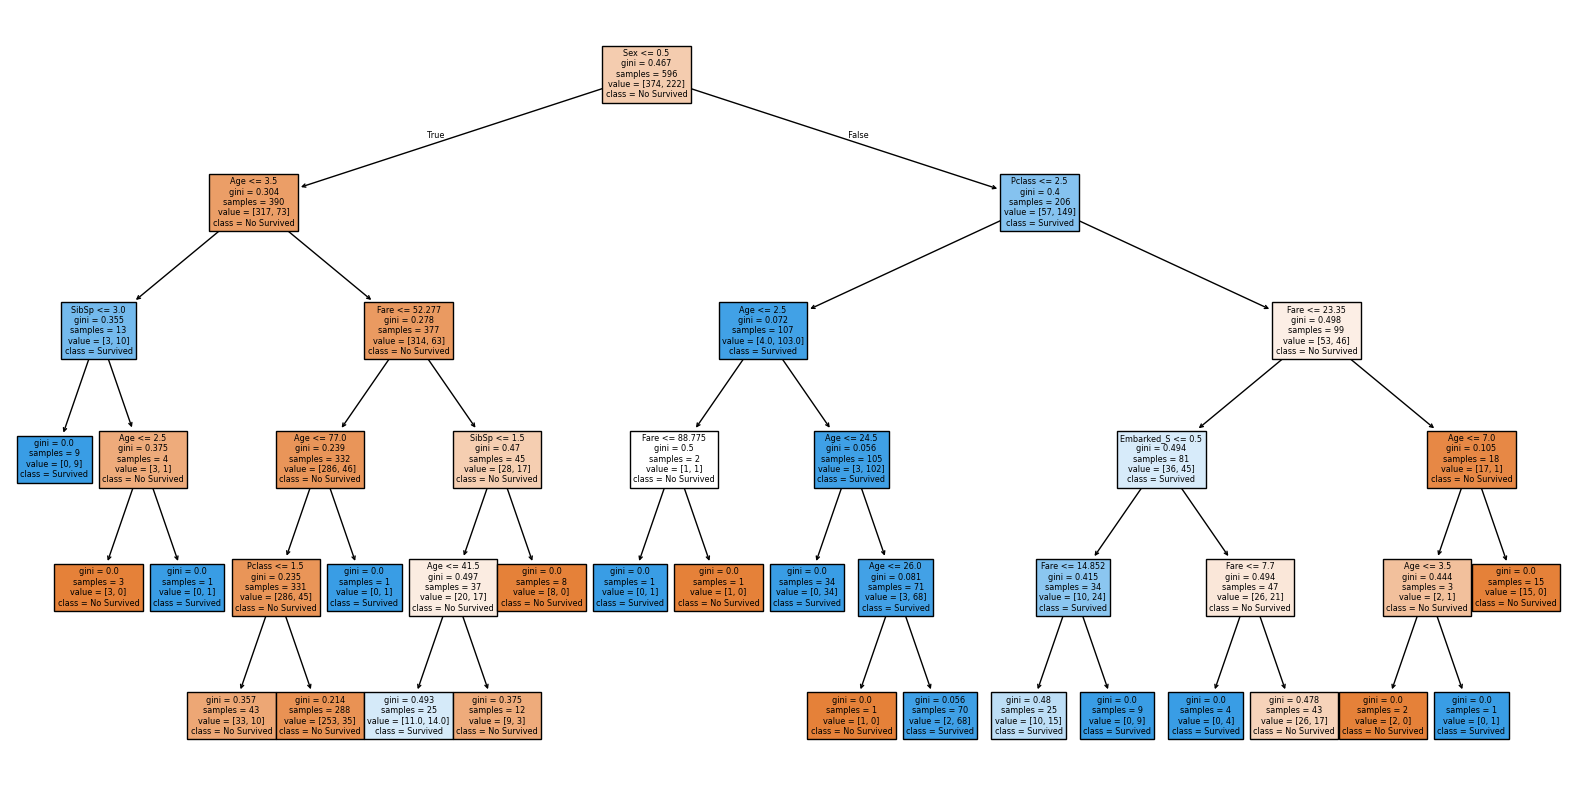

In [140]:
plt.figure(figsize=(20,10))
plot_tree(modelo, feature_names=X.columns, class_names=['No Survived', 'Survived'], filled=True)
plt.show()

# Optimizar el modelo de árbol de decisión utilizando GridSearchCV.

## Definir la cuadrícula de hiperparámetros

Especificar los rangos o valores de los hiperparámetros que queremos probar para optimizar el modelo (ej. `max_depth`, `min_samples_split`, `criterion`, 'class_weight', 'random_state').


**Razonamiento** : Defina la cuadrícula de hiperparameter para GridSearchCV como se especifica en las instrucciones.

In [148]:
#Seteamos el valor de Croos-Validation indicando 8 saltos estatificados, y lo mezclamos
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=21)

# Definir la grilla de hiperparámetros a probar
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced'],
    'random_state': [21]
}
print("Grilla de hiperparámetros definida:")
print(param_grid)

Grilla de hiperparámetros definida:
{'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced'], 'random_state': [21]}


## Configurar gridsearchcv



 Razonamiento : Configure el objeto GridSearchCV con el modelo definido, la cuadrícula de hiperparameter, los pliegues de validación cruzada y la métrica de puntuación



In [149]:
# 2. Configurar GridSearchCV
grid_search = GridSearchCV(estimator=modelo,
                           param_grid=param_grid,
                           cv=skf, # 8-fold cross-validation
                           scoring='f1', # Optimizar para F1-Score
                           n_jobs=-1) # Usar todos los núcleos disponibles
print("GridSearchCV configurado.")

GridSearchCV configurado.


## Entrenar con gridsearchcv

### Ajustar `GridSearchCV` a los datos de entrenamiento. Esto realizará la búsqueda de hiperparámetros utilizando validación cruzada.


In [150]:
# 3. Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)
print("GridSearchCV ajustado a los datos de entrenamiento.")

GridSearchCV ajustado a los datos de entrenamiento.


## Obtener el mejor modelo y los mejores hiperparámetros

### Una vez que `GridSearchCV` ha terminado, podemos acceder al mejor modelo encontrado y a la combinación de hiperparámetros que obtuvo el mejor rendimiento.


**Razonamiento**:
Acceder e imprimir los mejores hiperparámetros y el mejor modelo encontrado por GridSearchCV.






In [151]:
# Acceder al mejor modelo
best_model = grid_search.best_estimator_

# Acceder a los mejores hiperparámetros
best_params = grid_search.best_params_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(best_params)

# Imprimir el mejor modelo encontrado
print("\nMejor modelo encontrado:")
print(best_model)

Mejores hiperparámetros encontrados por GridSearchCV:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2, 'random_state': 21}

Mejor modelo encontrado:
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, random_state=21)


In [145]:
# Asegurarse de que las columnas de X_final_test coincidan con las columnas de X_train
# Esto es importante si hay diferencias en las columnas de one-hot encoding (aunque con drop_first=True y el mismo set de columnas iniciales, debería estar bien)
# Sin embargo, es una buena práctica verificar y realinear si es necesario.
missing_cols = set(X_train.columns) - set(X_final_test.columns)
for c in missing_cols:
    X_final_test[c] = 0
# Asegurarse de que el orden de las columnas sea el mismo
X_final_test = X_final_test[X_train.columns]


# Predecir en el conjunto de prueba final
predictions_test = best_model.predict(X_final_test)

# Mostrar las primeras predicciones
print("Primeras predicciones en el conjunto de prueba:")
print(predictions_test[:10])

Primeras predicciones en el conjunto de prueba:
[0 0 0 0 1 0 0 0 1 0]


## Evaluar el mejor modelo

### Evaluar el rendimiento del mejor modelo en el conjunto de validación (o en un conjunto de prueba separado si no se utilizó para la búsqueda de hiperparámetros).


**Reasoning**:
Calcule e imprima la precisión, el puntaje F1 y la recuperación del mejor modelo en el conjunto de validación.

In [152]:
# Predicion del set validacion usando el mejor modelo
y_pred_bmodel_val = best_model.predict(X_val)

# Calculo de evaluacion metrica por el mejor modelo en el set validacion
accuracy_bmodel_val = accuracy_score(y_val, y_pred_bmodel_val)
f1_bmodel_val = f1_score(y_val, y_pred_bmodel_val)
recall_bmodel_val = recall_score(y_val, y_pred_bmodel_val)
precision_bmodel_val = precision_score(y_val, y_pred_bmodel_val)

# Imprimir la evaluacion metrica
print(f"Metricas del mejor modelo de set validacion:")
print(f"Accuracy: {accuracy_bmodel_val:.4f}")
print(f"F1-Score: {f1_bmodel_val:.4f}")
print(f"Recall: {recall_bmodel_val:.4f}")
print(f"Precision: {precision_bmodel_val:.4f}")

Metricas del mejor modelo de set validacion:
Accuracy: 0.8373
F1-Score: 0.7876
Recall: 0.7417
Precision: 0.8396


### Análisis de datos

*   Se definió la cuadrícula de hiperparámetros para la optimización del modelo de árbol de decisión, incluidos los valores `max_depth`:[3, 5, 7, 10], `min_samples_split`:[2, 5, 10], y `criterion`:['gini', 'entropy'], 'class_weight': ['balanced'], 'random_state':[21]

*   GridSearchCV se configuró con un estimador de árbol de decisión, la cuadrícula de hiperparameter definida, la validación cruzada 8 veces y el uso del F1-score como la métrica de puntuación.

*   GridSearchCV se ajustó con éxito a los datos de entrenamiento (X_TRAIN , y_train), completando el proceso de búsqueda de hiperparámetros.


*   Los mejores hiperparámetros encontrados por GridSearchCV:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2, 'random_state': 21}



*   Mejor modelo encontrado:
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, random_state=21)

*   Se evaluó el rendimiento del mejor modelo en el conjunto de validación, que muestra Accuracy: 0.8203, una precisión de 0.8396, un F1-score de 0.7876 y un recall de 0.7417.


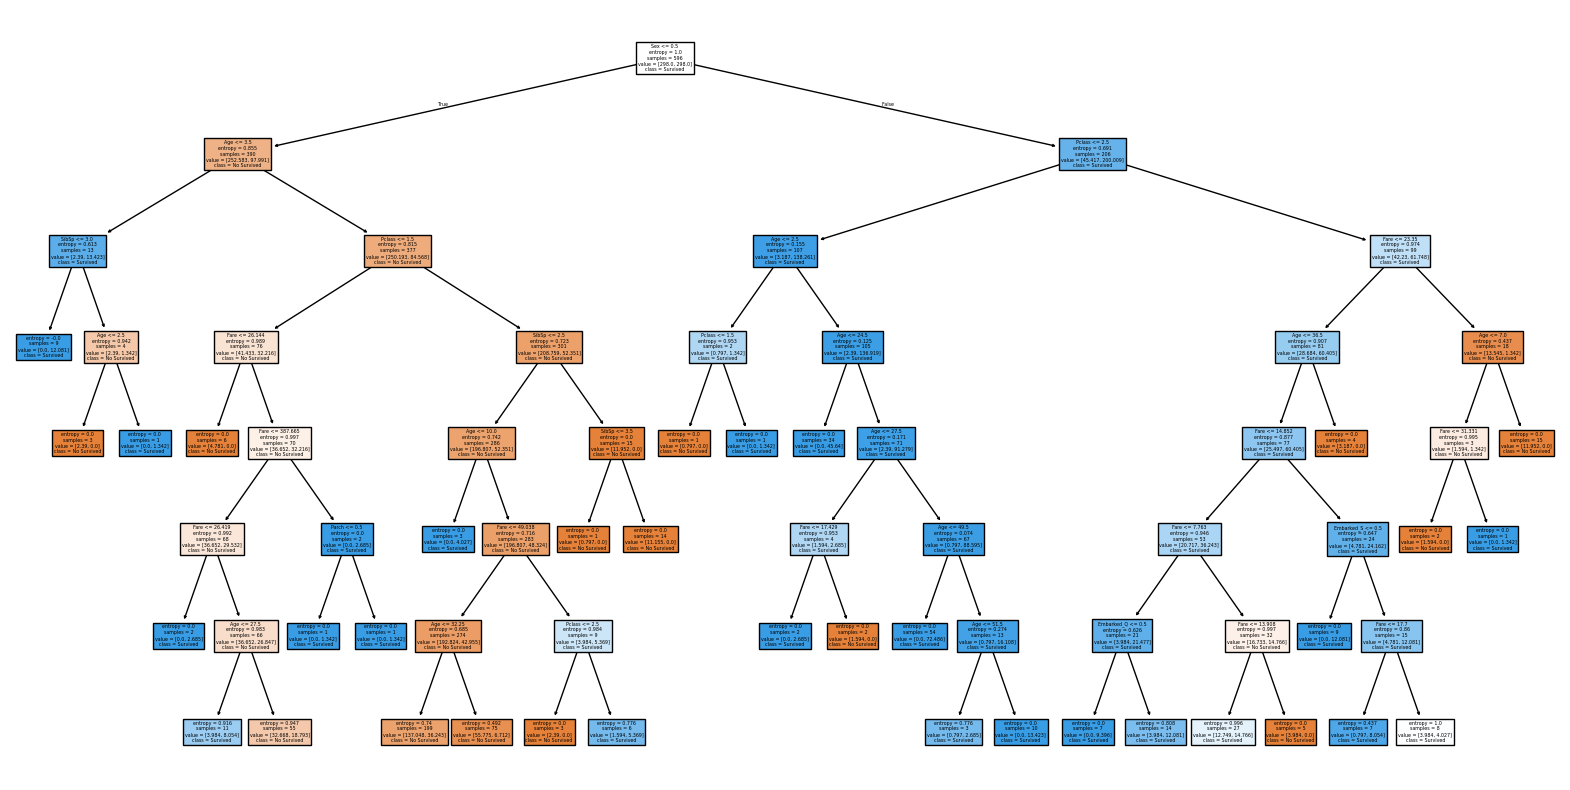

In [153]:
plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=X.columns, class_names=['No Survived', 'Survived'], filled=True)
plt.show()